#Main Idea Gastrointestinal Cancer Prediction คือ อะไร

##Input VDO and Retrive Image
1. Extract Image from VDO. สามารถกำหนด Time ในการคัดเลือก Frame Image ได้ เช่น ส่งไปในทุกๆ 3 วินาที
2. สร้าง Model Decision Image เลือกภาพที่ดีที่สุดจาก Frame Image เพื่อส่งให้ Model Prediction
3. Retrive Frame Image

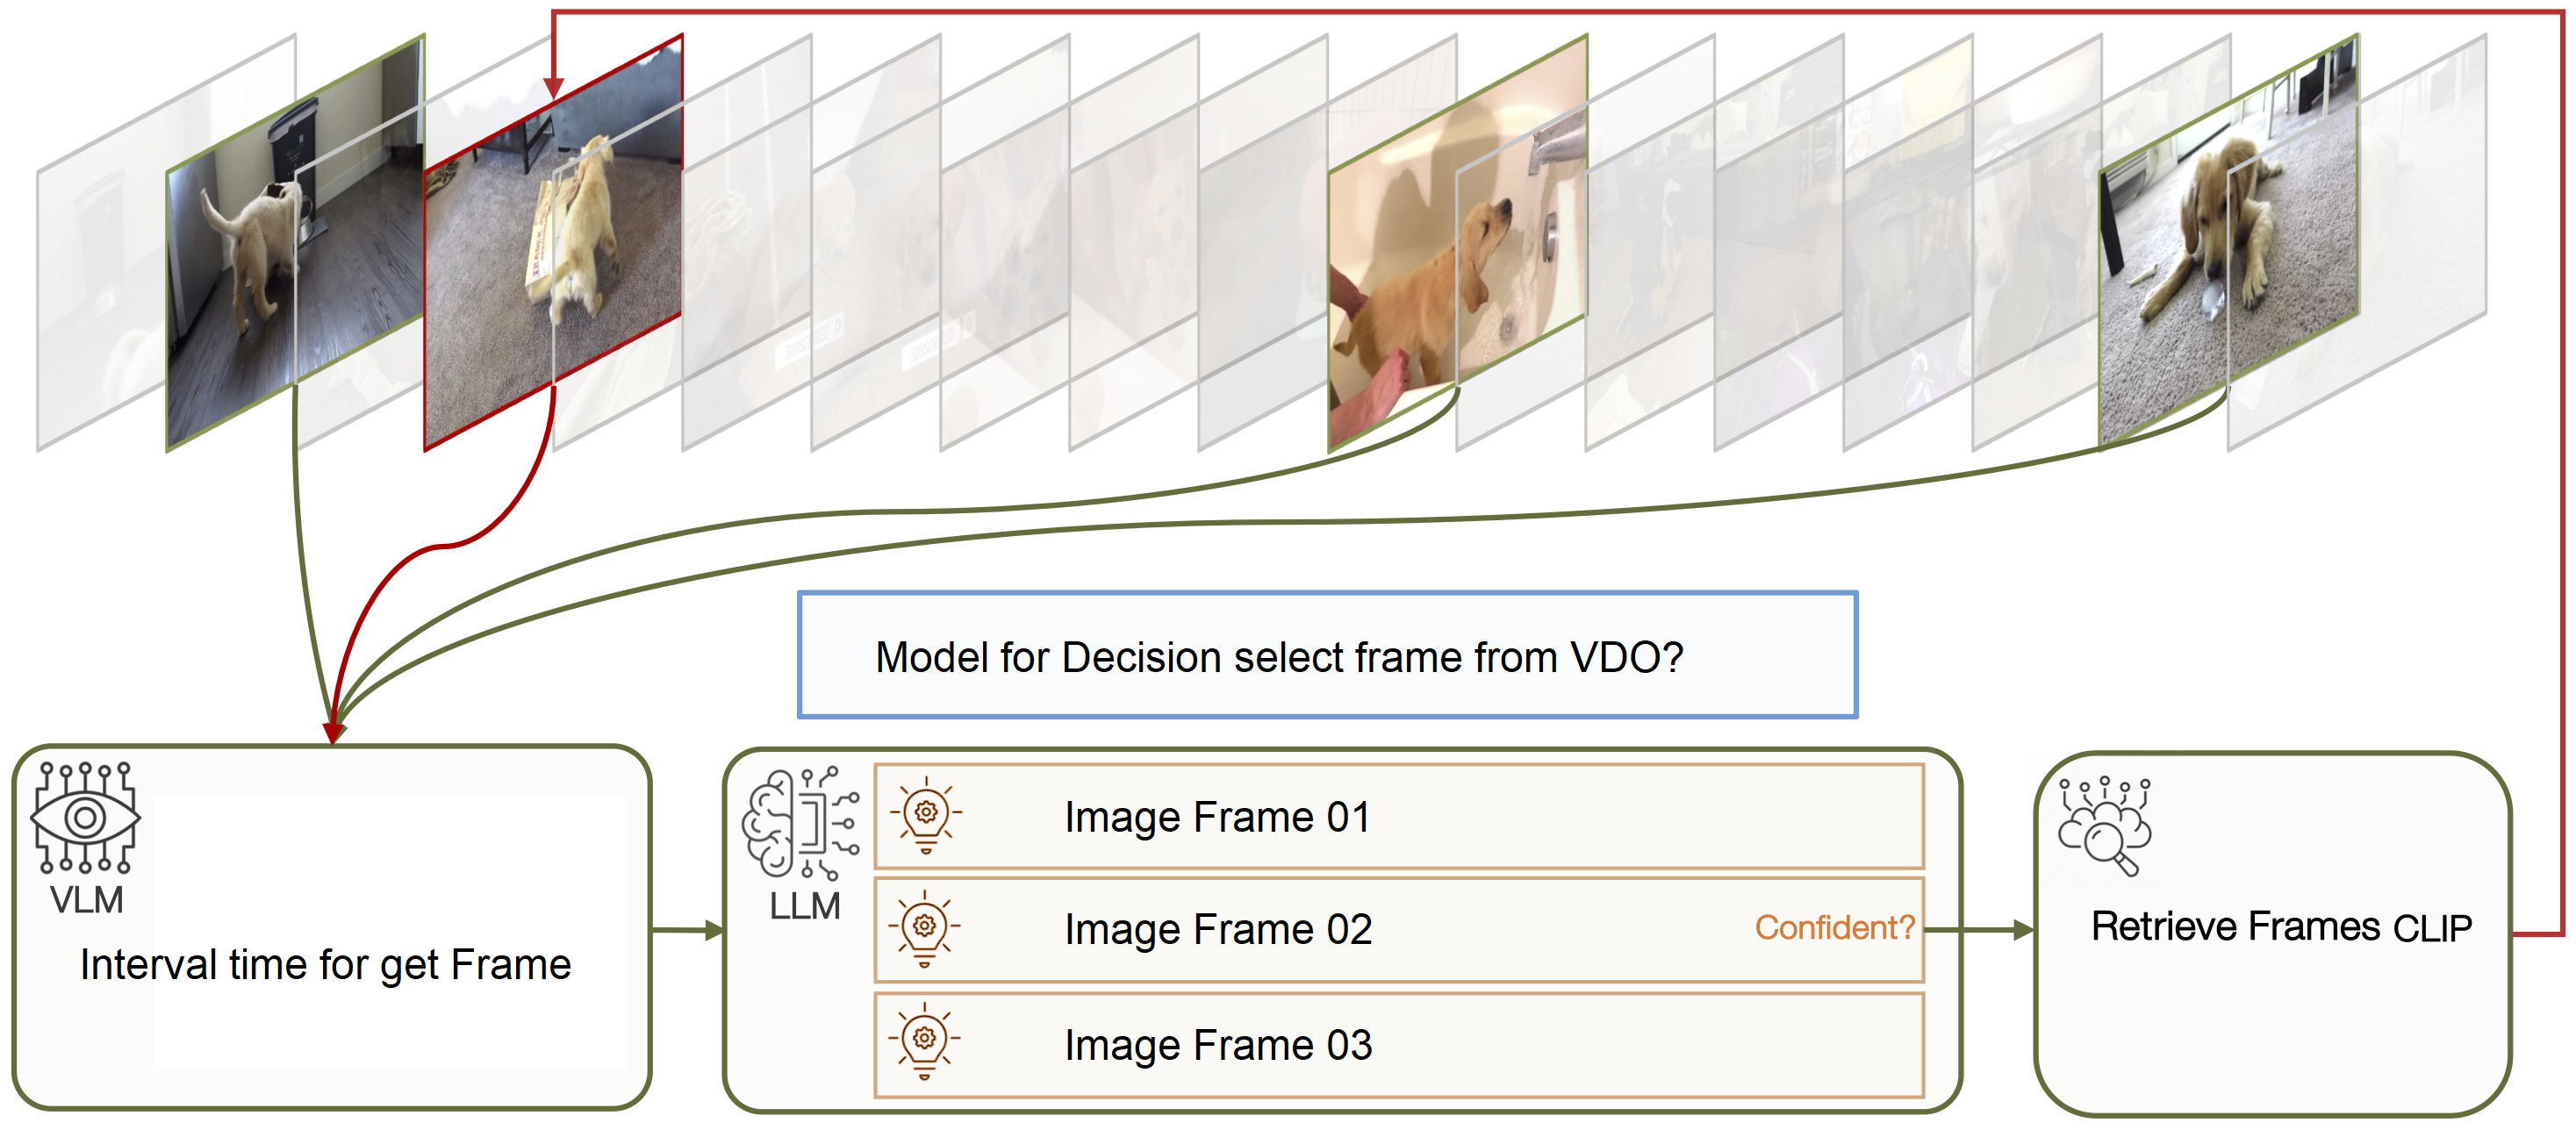


##Data Flow
วิดีโอ → Frame Extraction (≥30 FPS) → Normalization → CADe Model (Detection) → CADx Model (Diagnosis) → Real-Time Overlay (แสดงผลบนหน้าจอแพทย์) → Logging (บันทึกข้อมูล)

ระบบมีส่วนประกอบหลักสามารถแบ่งออกได้เป็น 3 ส่วนหลัก คือ

-	ส่วนประมวลผลวิดีโอ (Input/Pre-Processing)
-	ส่วน Core Model (Model/Engine)
-	ส่วนแสดงผล (Output/Interface)

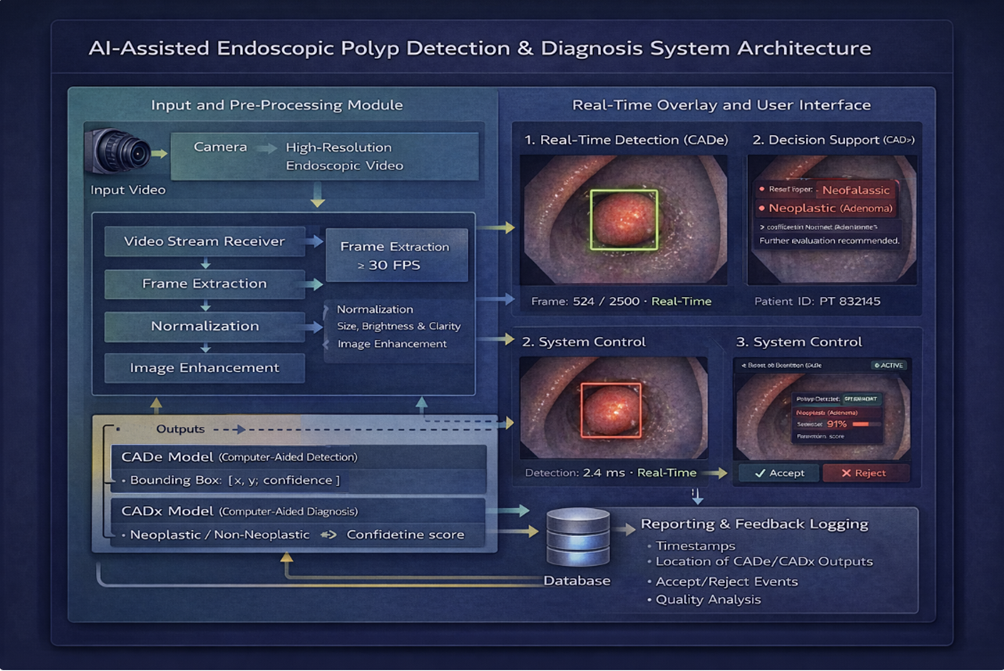


##Prediction
1. Train Model ด้วย Image และ Image label

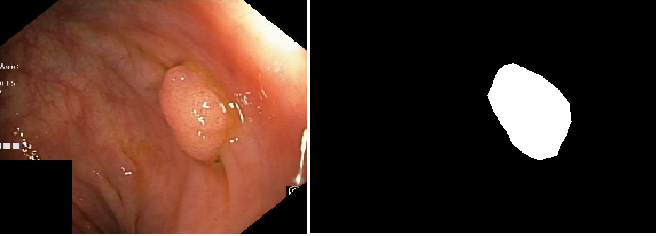

2. ส่ง Image เข้าไป Predicted Mask เพื่อหาจุด Mask ของรอยโรค

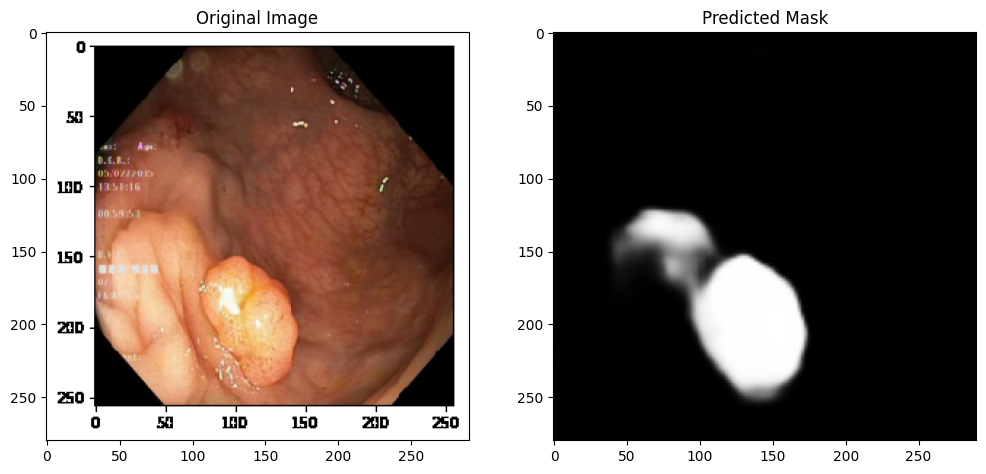

3. นำ Image เข้ามา Overlay ระหว่าง Original Image และ Predicion Mask

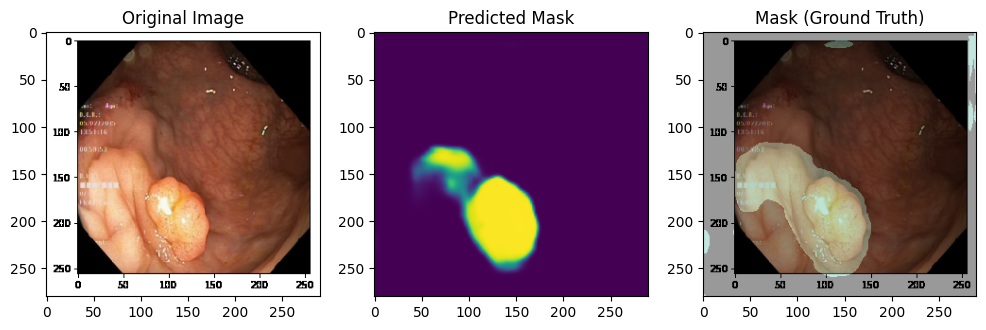


#Install Keras

In [ ]:
!pip install tensorflow keras opencv-python

#Import Libary

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

#1. กำหนด Path ของ Image
- Images สำหรับ Train model
- Image Label สำหรับ Train Model

ตัวอย่างของ Image ที่นำเอามา Train Model

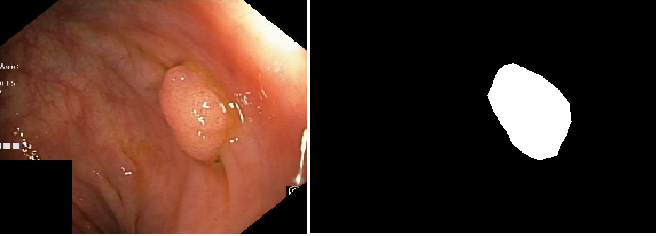


In [ ]:
image_dir = '/content/drive/MyDrive/GastrointestinalDataSet/images/'
mask_dir = '/content/drive/MyDrive/GastrointestinalDataSet/masks/'
test_dir = '/content/drive/MyDrive/GastrointestinalDataSet/test/'

images = []
masks = []


for img_name in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, img_name))
    img = cv2.resize(img, (128, 128))  # Resize to fit model input
    images.append(img)

    mask = cv2.imread(os.path.join(mask_dir, img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    masks.append(mask)

images = np.array(images) / 255.0  # Normalize images
masks = np.array(masks) / 255.0     # Normalize masks

##สร้าง U-NET Model

In [ ]:
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

##Fit Model โดยส่ง Image และ Image lable เข้าไป

In [ ]:
history = model.fit(images, masks.reshape(-1, 128, 128, 1), epochs=50)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 573ms/step - accuracy: 0.7833 - loss: 26.1349
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.8367 - loss: 0.3888
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.8374 - loss: 0.3555
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.8391 - loss: 0.3287
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.8463 - loss: 0.3344
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.8492 - loss: 0.3271
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.8563 - loss: 0.3212
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.8604 - loss: 0.3088
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.8602 - loss: 0.3084
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.8707 - loss: 0.2926
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.8688 - loss: 0.2912
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1

##Test Model
โดยการส่ง Image เข้าไปเพื่อให้ Model Prediction mask ตรงรอยของโรค

In [ ]:
test_image_path = '/content/drive/MyDrive/GastrointestinalDataSet/test/Test04.jpg'
test_image = cv2.imread(test_image_path)

# Get original dimensions
original_height_of_test_image, original_width_of_test_image = test_image.shape[:2]

# Resize the test image for model input
test_image_resized = cv2.resize(test_image, (128, 128)) / 255.0
test_image_input = np.expand_dims(test_image_resized, axis=0)  # Add batch dimension

# Predict the mask
predicted_mask = model.predict(test_image_input)[0]

# Resize predicted mask to original dimensions
predicted_mask_resized = cv2.resize(predicted_mask.squeeze(), (original_width_of_test_image, original_height_of_test_image))

# Convert predicted mask to uint8 for visualization
predicted_mask_resized_uint8 = (predicted_mask_resized * 255).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


###Plot Image Original and Prediction Mask

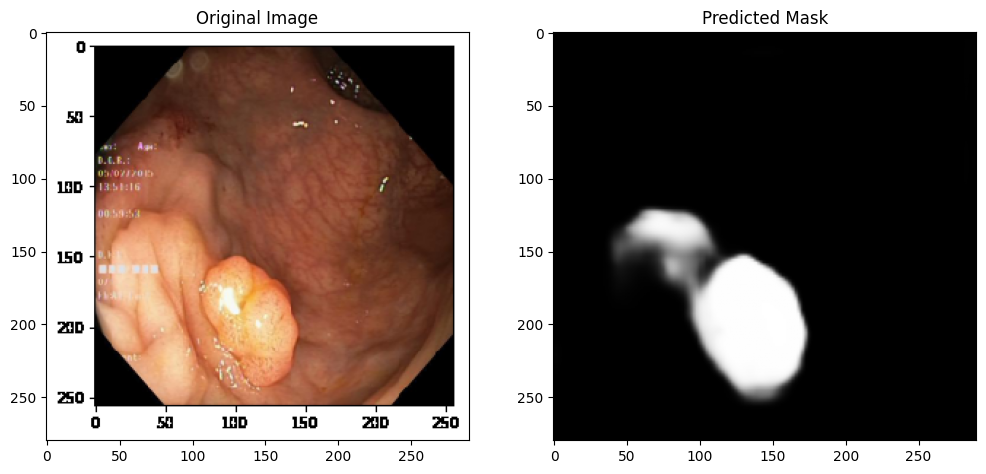

In [ ]:
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display

# Predicted Mask
plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask_resized_uint8, cmap="gray")  # Display mask as grayscale

plt.show()

#Prediction จาก Model
- แสดง Original Image
- แสดง Prediction Mask
- แสดง Mask (Ground Truth)

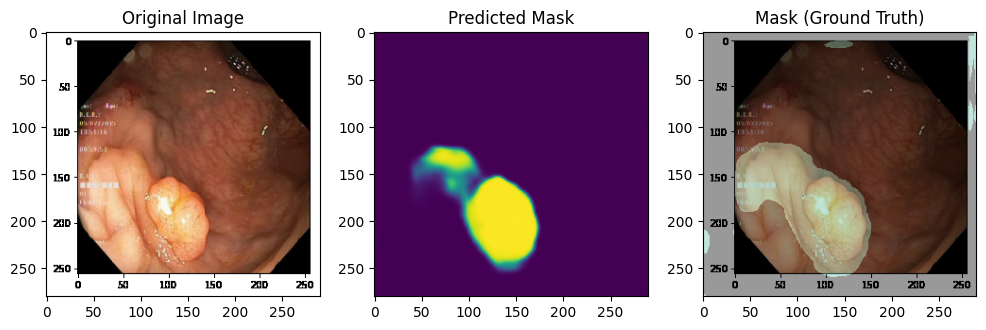

In [ ]:
def get_colored_mask(image, mask_image,color = [103,193,173]):
    # `mask_image` is expected to be a single-channel (grayscale) mask here.
    # Create a 3-channel colored version of the mask.
    colored_mask = np.zeros_like(image, dtype=np.uint8) # Create a black image with the same shape as the input image
    # Apply the specified color where the mask_image has non-zero values
    colored_mask[mask_image > 0] = color

    # Blend the original image with the colored mask
    ret = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
    return ret

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display

# Predicted Mask
plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask_resized_uint8)
#plt.imshow(predicted_mask_resized_uint8, cmap="gray")  # Display mask as grayscale

# Ground Truth Mask
plt.subplot(1,3,3)
plt.title('Mask (Ground Truth)')
plt.imshow(get_colored_mask(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB), predicted_mask_resized_uint8))

plt.show()

In [ ]:
#final_accuracy = history.history['accuracy'][-1]
#print(f"Final Training Accuracy: {final_accuracy:.4f}")

# Confidence can be interpreted in various ways. For a segmentation mask, the pixel values
# themselves represent the model's confidence (probability) that a pixel belongs to the mask.
# We can calculate the mean of these probabilities for an overall confidence score.
mean_predicted_confidence = np.mean(predicted_mask)
print(f"Mean Predicted Mask Confidence: {mean_predicted_confidence:.4f}")

Mean Predicted Mask Confidence: 0.0846
